In [0]:
#必要なパッケージのインポート
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# 以下，混合ポアソン分布モデルでのメトロポリスヘイスティング法の例

(array([37., 48., 21., 18., 20., 21., 26.,  7.,  1.,  1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

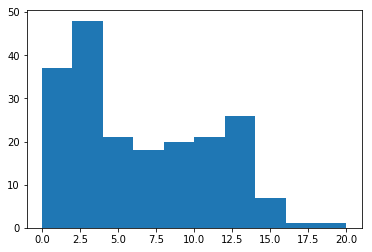

In [37]:
# データの生成
np.random.seed(seed=1)
n = 200 #サンプルサイズ
#真の分布を平均2のポアソン分布と平均10のポアソン分布の1:1の混合分布とする
data1 = np.random.poisson(2,n//2)
data2 = np.random.poisson(10,n//2)
data = np.concatenate([data1,data2])
plt.hist(data)

In [0]:
# 制御変数
H = 2 #コンポーネント数（今回はtrueと同じ2で固定）
K = 500 #サンプリング数
thin = 20 #サンプリング周期
burnin = 5000 #初期値の影響を切り捨てるバーンイン
iters = burnin + thin*K #実際の繰り返し回数
ep = 0.3 #提案分布の分散
# ハイパーパラメータ：簡単のため・クリティカルな影響を避けるために事前分布が正かつ有界になるように設定
a = 1 #コンポーネント共通のハイパラ
b = 1 #コンポーネント共通のハイパラ
phi = 1 #混合比の事前分布はディリクレ分布のなかでも一様分布になるとき


## モデリング

* モデル
$$p(x|w) = a\mathrm{Poi}(x|w_1) + (1-a)\mathrm{Poi}(x|w_2)=a\frac{w_1^x}{x!}\exp(-w_1) + (1-a)\frac{w_2^x}{x!}\exp(-w_2)$$

* 事前分布
$$\varphi_1(w) = \mathrm{Gam}(w_1|a=1,b=1)\mathrm{Gam}(w_2|a=1,b=1)
\propto \exp(-w_1-w_2),$$
$$\varphi_2(a) = \mathrm{Dir}(a|\phi=1)\propto const.,$$
$$\varphi(w,a)=\varphi_1(w)\varphi_2(a) \propto \exp(-w_1-w_2).$$

このとき，事後分布は

$$\psi(w,a|X^n) \propto \prod_{i=1}^n p(X_i|w)\varphi(w)$$

であり，エネルギー函数は，
$$H(w,a) =- \sum_{i=1}^n \log \left( a\frac{w_1^{X_i}}{X_i!}\exp(-w_1) + (1-a)\frac{w_2^{X_i}}{X_i!}\exp(-w_2) \right)+w_1+w_2.$$

エネルギー函数を簡単にするためにディリクレ分布のハイパーパラメータを1とした。

In [0]:
#MCMCの準備
def poisson_pmf(x,w):
  rv = scipy.stats.poisson(w)
  return rv.pmf(x)

def hamiltonian(w,a):
  pmmterm = a * poisson_pmf(data,w[0]) + (1-a) * poisson_pmf(data,w[1])
  first = -sum(np.log(pmmterm))
  second = sum(w)
  return first + second

def acceptance_ratio(source,target):
  delta = hamiltonian(target[0],target[1]) - hamiltonian(source[0],source[1])
  prob = min(1, np.exp(-delta))
  return prob

#パラメータの初期値
w = np.array([5.0,7.0])
a = 0.5

all_ws = np.zeros([iters,H])
ws = np.zeros([K,H])
all_aparams = np.zeros(iters)
aparams = np.zeros(K)

accept_counter = 0

In [40]:
#MCMC
##サンプリング
for iter in range(iters):
  delta_w = ep*np.random.randn()
  delta_a = ep*np.random.randn()
  source = (w,a)
  target = (w + delta_w, (a + delta_a)%1) # a in [0,1]
  r = acceptance_ratio(source,target)
  R = np.random.rand()
  w += (r>=R) * delta_w
  a = (a + (r>=R) * delta_a)%1
  accept_counter += (r>=R)*1
  all_ws[iter] = w
  all_aparams[iter] = a
  #if iter%400==0:
    #print(accept_counter/ (iters+0.0) )
##バーンインとシニング
for i in range(K):
  ws[i] = all_ws[burnin + thin*i]
  aparams[i] = all_aparams[burnin + thin*i]

#事後分布を書けと言われたらall_wsではなくwsのヒストグラムになることに注意！
print("採択確率：",accept_counter/(iters+0.0))

採択確率： 0.1582


(array([  2.,   8.,  25.,  68., 105., 112.,  99.,  56.,  16.,   9.]),
 array([0.2767236 , 0.31366688, 0.35061015, 0.38755343, 0.4244967 ,
        0.46143998, 0.49838325, 0.53532653, 0.5722698 , 0.60921308,
        0.64615635]),
 <a list of 10 Patch objects>)

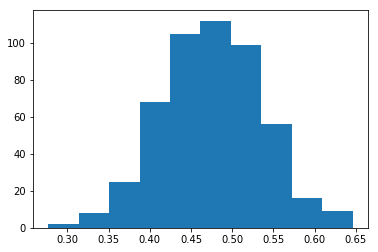

In [41]:
#混合比のヒストグラム
plt.hist(aparams)

(array([  9.,  16.,  56.,  99., 112., 105.,  68.,  25.,   8.,   2.]),
 array([0.35384365, 0.39078692, 0.4277302 , 0.46467347, 0.50161675,
        0.53856002, 0.5755033 , 0.61244657, 0.64938985, 0.68633312,
        0.7232764 ]),
 <a list of 10 Patch objects>)

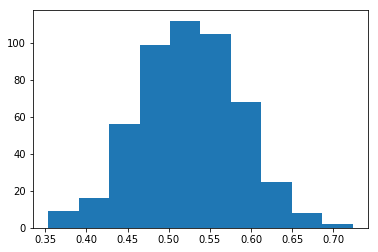

In [42]:
#もう片方の混合比
plt.hist(1-aparams)

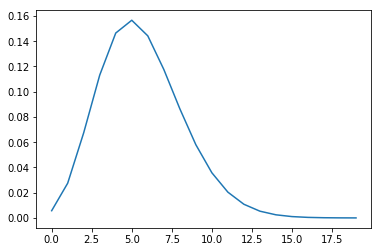

In [43]:
##予測分布の計算
plot_x = np.linspace(0,19,20)

predict =np.array([
    np.mean(np.array([aparams[k]*poisson_pmf(x,ws[k,0])
                      + (1-aparams[k])*poisson_pmf(x,ws[k,1]) for k in range(K)]
                    ))
    for x in plot_x
])
plt.plot(plot_x,predict)